In [1]:
from neutral_diffusion import Neutral_Diffusion_Driver
import sys
sys.path.insert(0, '/home/ashao/git/ppm_mom6/')
from ppm_mom6 import ppm_mom6
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import gsw
import numpy as np
%matplotlib inline
ppm_reconstruct = ppm_mom6.ppm_reconstructions
plm_reconstruct = ppm_mom6.plm_reconstructions

In [2]:
CS = Neutral_Diffusion_Driver.neutral_diffusion_init(0., "PLM", False, True, 1.e-10, 10, "WRIGHT")

In [3]:
demo_vars = Dataset('/home/ashao/git/ashao_forks/MOM6-examples/ocean_only/tracer_mixing/rho/Initial_state.nc').variables
temp = demo_vars['Temp'][0,:,1,:]
salt = demo_vars['Salt'][0,:,1,:]
rho = gsw.sigma0(salt,temp)
h = demo_vars['h'][0,:,1,:]
nk = h.shape[0]
Dataset('/home/ashao/git/ashao_forks/MOM6-examples/ocean_only/tracer_mixing/z_wright/Initial_state.nc').close()

In [4]:
ns = 4*nk
PoL = np.zeros(ns, dtype = np.float64)
PoR = np.zeros(ns, dtype = np.float64)
hEff = np.zeros(ns-1, dtype = np.float64)
KoL = np.zeros(ns, dtype = np.int32)
KoR = np.zeros(ns, dtype = np.int32)
xidx = 15;
hl = h[:,xidx] ; Tl = temp[:,xidx] ; Sl = salt[:,xidx]
hr = h[:,xidx+1] ; Tr = temp[:,xidx+1] ; Sr = salt[:,xidx+1]

Neutral_Diffusion_Driver.find_neutral_surfaces(CS,nk,Tl,Sl,hl,Tr,Sr,hr,PoL, PoR, KoL, KoR, hEff)
print(hEff.sum())

74.1446266643


In [5]:
def plot_density_reconstruction(zi_depth, S_coeffs, T_coeffs, ls = 'k-', nint = 11):
    nk = zi_depth.size-1
    z_nondim = np.linspace(0,1,nint)
    for k in range(0,nk):
        z = np.linspace(zi_depth[k],zi_depth[k+1],nint)
        T = np.polyval(T_coeffs[k,:],z_nondim)
        S = np.polyval(S_coeffs[k,:],z_nondim)
        rho0 = gsw.sigma0(S,T)
        plt.plot(rho0, z, ls, lw = 2)
        
def rho_at_nondim(S_coeff, T_coeff, k, p):
    S = np.polyval(S_coeff[k,:],p)
    T = np.polyval(T_coeff[k,:],p)
    return gsw.sigma0(S,T)

def plot_neutral_surfaces(CS, hl, Tl, Sl, hr, Tr, Sr, PoL, PoR, KoL, KoR, hEff):
    if CS.ppoly_deg==1:
        reconstruct = plm_reconstruct
    elif CS.ppoly_deg==2:
        reconstruct = ppm_reconstruct
    else:
        raise NameError("Invalid degree of polynomial")
    # Build reconstructions
    _, Tl_coeff = reconstruct(hl, Tl) ; Tl_coeff = np.fliplr(Tl_coeff)
    _, Sl_coeff = reconstruct(hl, Sl) ; Sl_coeff = np.fliplr(Sl_coeff)
    _, Tr_coeff = reconstruct(hr, Tr) ; Tr_coeff = np.fliplr(Tr_coeff)
    _, Sr_coeff = reconstruct(hr, Sr) ; Sr_coeff = np.fliplr(Sr_coeff)
    
    # Plot depths of interfaces
    zi_l = np.append(0.,hl.cumsum())
    zi_r = np.append(0.,hr.cumsum())
    plot_density_reconstruction(zi_l, Sl_coeff, Tl_coeff, ls = 'k-')
    plot_density_reconstruction(zi_r, Sr_coeff, Tr_coeff, ls = 'k-')
    plt.gca().invert_yaxis()
    ns = PoL.size
    for k in range(0,ns-1):
        if hEff[k] > 0.:
            # Bottom surface
            z_nd = PoL[k] ; Kl = KoL[k]-1
            rho_l = rho_at_nondim(Sl_coeff, Tl_coeff, Kl, z_nd)
            zs_l = zi_l[Kl]*(1-z_nd) + zi_l[Kl+1]*z_nd
            z_nd = PoR[k] ; Kr = KoR[k]-1
            rho_r = rho_at_nondim(Sr_coeff, Tr_coeff, Kr, z_nd)
            zs_r = zi_r[Kr]*(1-z_nd) + zi_r[Kr+1]*z_nd
            plt.plot([rho_l,rho_r],[zs_l,zs_r],'b-.')
            # Top surface
            z_nd = PoL[k+1] ; Kl = KoL[k+1]-1
            rho_l = rho_at_nondim(Sl_coeff, Tl_coeff, Kl, z_nd)
            zs_l = zi_l[Kl]*(1-z_nd) + zi_l[Kl+1]*z_nd
            z_nd = PoR[k+1] ; Kr = KoR[k+1]-1
            rho_r = rho_at_nondim(Sr_coeff, Tr_coeff, Kr, z_nd)
            zs_r = zi_r[Kr]*(1-z_nd) + zi_r[Kr+1]*z_nd
            plt.plot([rho_l,rho_r],[zs_l,zs_r],'r--')

(0, 100)

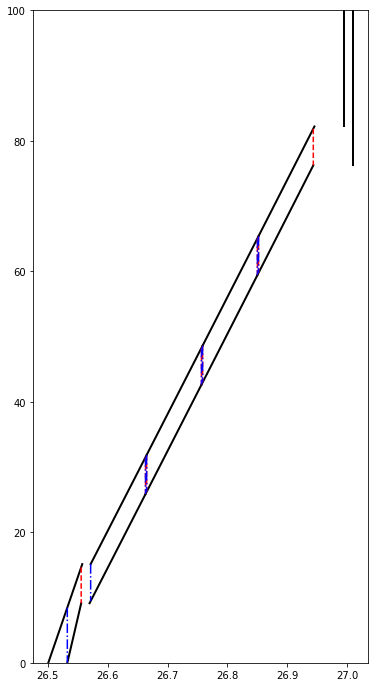

In [6]:
plt.figure(figsize=(6,12))
plot_neutral_surfaces(CS,hl,Tl,Sl,hr,Tr,Sr,PoL,PoR,KoL,KoR,hEff)
# plt.ylim(0,50) ; plt.xlim(26.64,26.74)
# plt.ylim(90,100)
# plt.xlim(26.9,27.1)
plt.ylim(0,100)